In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys

% matplotlib notebook

In [2]:
def evaluate(k, M, files):
    n = 0
    for j, i in enumerate(M):
        topk = i.argsort()[-k:]

        if files[j][:6] in (files[index][:6] for index in topk):
            n += 1
            
    return n * 1.0 / len(files)

In [3]:
def compute_distance(x,y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.linalg.norm(x-y)

In [4]:
def calculate_jain_results(cut, i):
    
    jain_base_dir = '/fileserver/nmec-handwriting/stil-writing-corpus-processed/'
    
    path = jain_base_dir + cut + '/FR-Comps'
    files = os.listdir(path)
    files.sort()
    
    the_file = files[0]
    metric=[]
    for the_file in files:
      filename = path + '/' + the_file
      corpfile = open(filename, 'r').read().splitlines()
      metricline = [np.array([corpline.split(' ')[1] for corpline in corpfile]).astype(np.float32)]
      metric += metricline
    metric = np.array(metric)
    F = -metric
    np.fill_diagonal(F, -1)
    
    return np.array([evaluate(k, F, files) for k in range(1, i + 1)])

## Get the results of the JAIN feature cuts and classification

In [5]:
cuts = np.array(['vertfeats','seamfeats','TASfeats'])
jain_base_dir = '/fileserver/nmec-handwriting/stil-writing-corpus-processed/'
results = np.array([calculate_jain_results(cut, 100) for cut in cuts])

## Get feature files from D-Script

In [7]:
feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_denoised_cc_deNNiam_fiel657_min500/'

files = os.listdir(feature_dir)
files.sort()

feature_map = []
for i,filename in enumerate(files):
    path = feature_dir + "/" + filename
    #if os.path.isfile(path) and ( '004.' in filename or '007.' in filename):
    if os.path.isfile(path):
        try:
            feature_map.append( np.load(path).mean(axis=0) )
        except:
            feature_map.append( np.ones([1,4096]) * sys.maxint)
        
feature_map = np.array(feature_map)

## Calculate Distances

In [8]:
metric = []
for i, image in enumerate(feature_map):
    metricline = [np.array([compute_distance(image, other) for other in feature_map])]
    metric += metricline

metric = np.array(metric)
F = -metric
np.fill_diagonal(F, -sys.maxint)

x = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

## Plot results

<IPython.core.display.Javascript object>


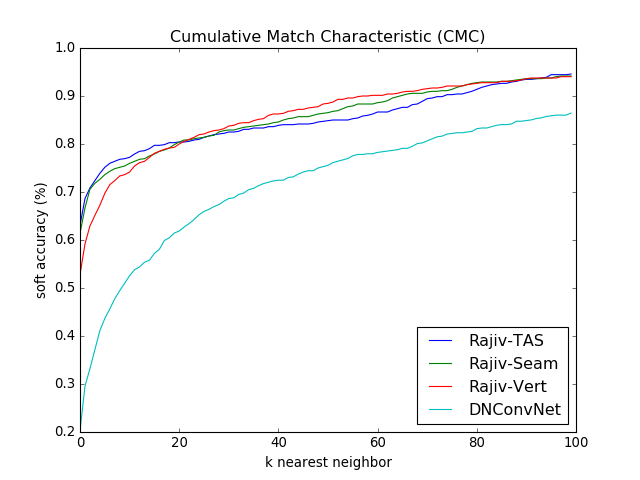

In [17]:
plt.figure()
for result in results:
    plt.plot(result)
plt.plot(x)
plt.xlabel('k nearest neighbor')
plt.ylabel('soft accuracy (%)')
plt.title('Cumulative Match Characteristic (CMC)')
plt.legend(['Rajiv-TAS','Rajiv-Seam','Rajiv-Vert', 'DNConvNet'],loc=4)